In [86]:
import pandas as pd
import numpy as np 
import matplotlib as plt

# models 
from sklearn.linear_model import LogisticRegression

# model selection
from sklearn.model_selection import GridSearchCV

#metrics
from sklearn.metrics import precision_score, classification_report, confusion_matrix,f1_score
from sklearn.model_selection import RepeatedStratifiedKFold

#smote 
from imblearn.over_sampling import SMOTE

# data
from sklearn.model_selection import train_test_split

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Models
from sklearn.ensemble import GradientBoostingClassifier

# Data Import and Split 

In [87]:
df_to_models = pd.read_csv(r'../data/to_models.csv', index_col=0)
y = pd.read_csv(r'../data/y.csv', index_col=0)

In [88]:
# creating train/val and test dataframes 
X_train_val, X_test, y_train_val, y_test = train_test_split(df_to_models, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=15, 
                                                    shuffle=True, 
                                                    stratify=y
                                                   )

# Functions to Test Models 

In [89]:
def metrics(X_train, X_val, y_train, pred_train , y_val, pred_val, model):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print("Score: "+ str(model.score(X_train, y_train)))
    print("F1 Score: "+ str(f1_score(y_train, pred_train)))

    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    print("Score: "+ str(model.score(X_val, y_val)))
    print("F1 Score: "+ str(f1_score(y_val, pred_val)))

In [117]:
def avg_score(model, data_to_slice, y_to_slice, columns_to_use, smote = True, rsk_splits = 5, rspk_repeats = 5, feat_sel = False):
    # apply kfold
    skf = RepeatedStratifiedKFold(n_splits=rsk_splits, n_repeats=rspk_repeats)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    f1_list = []
    precision_list = []
    tn_avg = 0
    fp_avg = 0
    fn_avg = 0
    tp_avg = 0
    count = 0
    flag = 0 # feat sel flag to not keep printing 

    for train_index, test_index in skf.split(data_to_slice[columns_to_use],y_to_slice):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = data_to_slice[columns_to_use].iloc[train_index], data_to_slice[columns_to_use].iloc[test_index]
        y_train, y_val = y_to_slice.iloc[train_index], y.iloc[test_index]
        
        # SMOTE É AQUI 
        if smote: 
            smote = SMOTE(random_state = 11)
            X_train, y_train = smote.fit_resample(X_train, y_train)


        # applies the model 
        model_fit = model.fit(X_train, y_train)
        # predicts training 
        y_pred_train =  model_fit.predict(X_train)
        #predicts validation 
        y_pred_val = model_fit.predict(X_val)


        if feat_sel is True: 
            if hasattr(model_fit, 'feature_importances_'):
                feat_imp = pd.Series(model_fit.feature_importances_, columns_to_use).sort_values(ascending=False)
                feat_imp.plot(kind='bar', title='Feature Importances')

            elif flag == 0: 
                flag = 1
                print("This model has no feat_sel attb")
            else: 
                continue
        # prints metric results         
        #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)



        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
        count += 1
        tn_avg += tn
        fp_avg += fp
        fn_avg += fn
        tp_avg += tp

        
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        f1_score_val = f1_score(y_val, y_pred_val)
        prec_score = precision_score(y_val, y_pred_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        f1_list.append(f1_score_val)
        precision_list.append(prec_score)
        
  
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_f1 = round(np.mean(f1_list),3)
    std_f1 = round(np.std(f1_list),2)
    avg_precision = round(np.mean(precision_list),3)
    std_precision = round(np.std(precision_list),2)

    tn_avg = tn_avg / count
    fp_avg = fp_avg / count
    fn_avg = fn_avg / count
    tp_avg = tp_avg / count
    #print(confusion_matrix(y_val, y_pred_val))
    confmatrix = str(tp_avg)+ ' , ' + str(tn_avg) + ' \n ' + str(fp_avg) + ' , ' +  str(fn_avg)
    return str(avg_train) + '+/-' + str(std_train),\
            str(avg_test) + '+/-' + str(std_test) , str(avg_f1) + '+/-' + str(std_f1), str(avg_precision), confmatrix

## Logistic Regression

In [93]:
LogReg = LogisticRegression()

avg_score(LogReg, X_train_val, y_train_val,X_train_val.columns, smote = False, feat_sel=True)


This model has no feat_sel attb


('0.786+/-0.0',
 '0.565+/-0.0',
 '0.257+/-0.0',
 0.369,
 '641.0 , 4158.0 \n 1094.0 , 2605.0')

## Gradient Boost 

In [94]:
from sklearn.ensemble import GradientBoostingClassifier

In [95]:
gbm0 = GradientBoostingClassifier(random_state=10)

#### Small FeatSel for this specific model 

In [118]:
#Choose all predictors except target & IDcols
avg_score(gbm0, X_train_val, y_train_val, X_train_val.columns,True,2,2)

('0.813+/-0.0',
 '0.549+/-0.0',
 '0.344+/-0.02',
 '0.38',
 '2517.0 , 9145.75 \n 4102.25 , 5479.0')

## 

In [67]:
gb_feats = ['TotalOfSpecialRequests', 'x6_super_booker', 'LeadTime',
             'PreviousCancellations', 'x1_Non Refund', 'x1_No Deposit',
             'x0_Transient','RequiredCarParkingSpaces','ADR','BookingChanges']

In [63]:
# tree param - min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_depth, max_leaf_nodes, max_features
# boost param - learning_rate, n_estimators, subsample


In [116]:
# tree params
# tree params
param_grid = {
    'min_samples_split':[10,50,100,500,1000,2000],
    'min_samples_leaf' :[10,50,100,500,1000,2000],    
    'max_depth': [4,8,10,25],
    'max_features': ['sqrt'],
    'learning_rate': [0.01, 0.03,0.05, 0.1],
    'n_estimators': range(50,200,400)
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm0, param_grid = param_grid, scoring = 'precision')

grid_search.fit(X_train_val, y_train_val)
grid_search.best_params_, grid_search.best_score_

({'learning_rate': 0.01,
  'max_depth': 4,
  'max_features': 'sqrt',
  'min_samples_leaf': 10,
  'min_samples_split': 10,
  'n_estimators': 50},
 1.0)

In [119]:
gbm1 = GradientBoostingClassifier(random_state=10, learning_rate=0.01, max_depth=4, max_features='sqrt', min_samples_leaf=10, min_samples_split=10,n_estimators=50)

('0.746+/-0.0',
 '0.518+/-0.0',
 '0.401+/-0.0',
 '0.377',
 '3423.25 , 7583.5 \n 5664.5 , 4572.75')

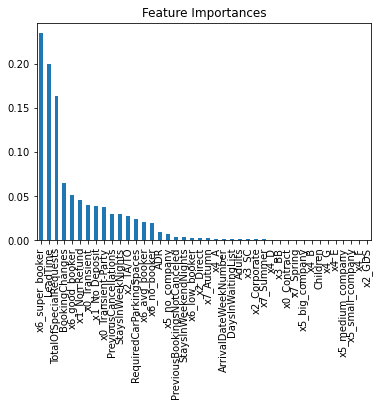

In [120]:
avg_score(gbm1, X_train_val, y_train_val, X_train_val.columns,True,2,2,feat_sel=True)